# 자전거 대여 데이터

- 2011년부터 2012년까지 2년간의 자전거 대여 데이터
- 캐피털 바이크셰어 회사가 공개한 운행 기록에 다양한 외부 소스에서 얻은 당시 날씨 정보를 조합
- 한 시간 간격으로 기록됨
- 훈련 데이터 : 매달 1일부터 19일 까지의 기록
- 테스트 데이터 : 매달 20일부터 월말까지의 기록
- 피처
    - datetime : 기록 일시(1시간 간격)
    - season : 계절
        - 1 : 봄(1분기)
        - 2 : 여름(2분기)
        - 3 : 가을(3분기)
        - 4 : 겨울(4분기)
        - 공식 문서에는 계절로 설명하고 있지만 실제로는 분기로 나누어져 있음
    - holiday : 공휴일 여부(0 : 공휴일 아님, 1: 공휴일)
    - workingday : 근무일 여부(0 : 근무일 아님, 1 : 근무일)
        - 주말과 공휴일이 아니면 근무일이라고 간주
    - weather : 날씨
        - 1 : 맑음
        - 2 : 옅은 안개, 약간 흐림
        - 3 : 약간의 눈, 약간의 비와 천둥 번개, 흐림
        - 4 : 폭우와 천둥 번개, 눈과 짙은 안개
        - 숫자가 클수록 날씨가 안 좋음
    - temp : 실제 온도
    - atemp : 체감온도
    - humidity : 상대 습도
    - windspeed : 풍속
    - casual : 등록되지 않은 사용자(비회원) 수
    - registered : 등록된 사용자(회원) 수
    - count : 자전거 대여 수량
- 종속변수 : count
- 평가지표 : RMSLE(Root Mean Squared Logarithmic Error), 0.37

In [683]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_log_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import math

In [415]:
def rmsle(y_true, y_pred, convertExp = True):
    '''
    실제 타깃값과 예측값을 인수로 전달하면 RMSLE 수치를 반환하는 함수
    convertExp : 입력 데이터를 지수변환할지 정하는 파라미터
    타깃값으로 log(count)를 사용한 경우에는 지수변환을 해줘야 함
    '''
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))

    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))

    return output

In [756]:
df = pd.read_csv("./data/bike/train.csv")
test_df = pd.read_csv("./data/bike/test.csv")

In [757]:
x = df.drop(["datetime", "casual", "registered","count"], axis = 1)
y1 = df["casual"]
y2 = df["registered"]
y3 = df["count"]

In [758]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [759]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [760]:
ss = StandardScaler()
mm = MinMaxScaler()
scaled_x = mm.fit_transform(x)
scaled_x = pd.DataFrame(scaled_x, columns = x.columns)

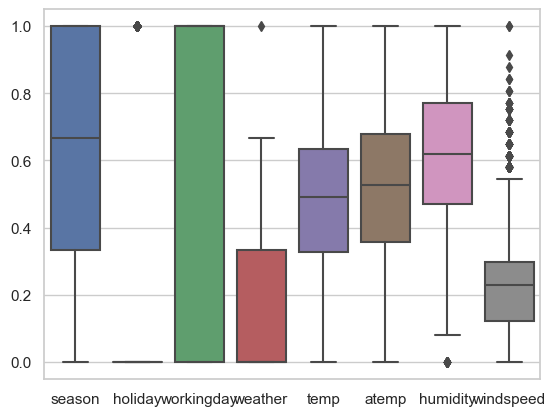

In [761]:
sns.set_theme(style = "whitegrid")

plt.figure()
sns.boxplot(scaled_x)
plt.show()

df.loc[df["humidity"] == 0, "humidity"] = df[df["humidity"] != 0]["humidity"].min()

In [762]:
# season을 제거하고 월을 쓰기위한 데이터 변환
df["month"] = df['datetime'].apply(lambda x: int(x[5:7]))
df["time"] = df['datetime'].apply(lambda x: int(x[11:13]))

In [ ]:
use_df = df.drop("season", axis = 1)
#use_df = use_df.drop("holiday", axis = 1)
onehot_month = pd.get_dummies(df["month"], dtype = int)
onehot_month.columns = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
onehot_time = pd.get_dummies(df["time"], dtype = int)
onehot_time.columns = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
                        "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23"]


use_df = pd.concat([use_df, onehot_month, onehot_time], axis = 1).drop(["month", "time"], axis = 1)
use_df = use_df.drop("temp", axis = 1)

In [745]:
use_df.describe()

,holiday,workingday,weather,atemp,humidity,windspeed,casual,registered,count,Jan,...,14,15,16,17,18,19,20,21,22,23
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,1.418427,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,0.081205,...,0.041889,0.041889,0.041889,0.041889,0.041889,0.041889,0.041889,0.041889,0.041889,0.041889
std,0.166599,0.466159,0.633839,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.273163,...,0.200344,0.200344,0.200344,0.200344,0.200344,0.200344,0.200344,0.200344,0.200344,0.200344
min,0.000000,0.000000,1.000000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,2.000000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,4.000000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [746]:
scaled_df = pd.DataFrame(ss.fit_transform(use_df[["windspeed", "humidity", "atemp", "weather"]]), columns = ["windspeed", "humidity", "atemp", "weather"])
scaled_df = pd.concat([scaled_df, use_df.drop(["windspeed", "humidity", "atemp", "weather"], axis = 1)], axis = 1)

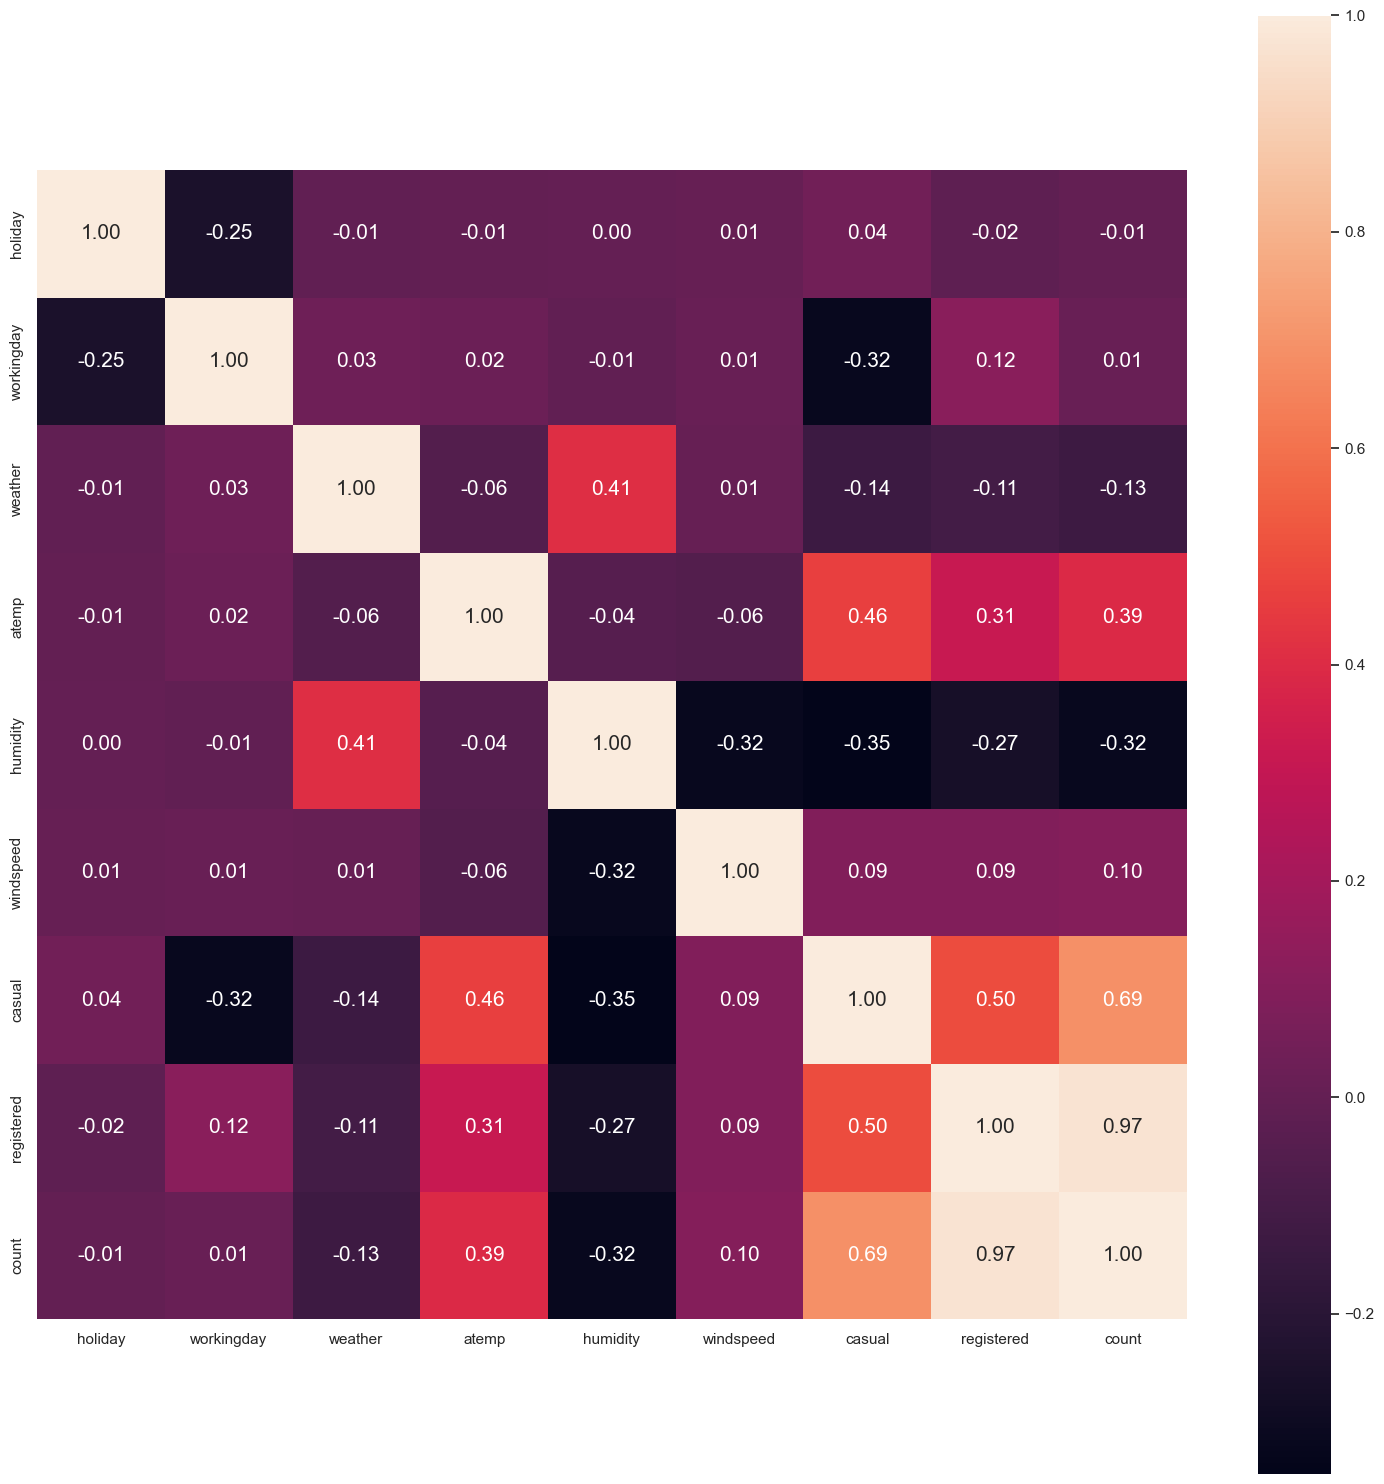

In [747]:
plt.figure(figsize = (15, 15))
co_df = use_df.iloc[:,1:10]
corr = co_df.corr()
hm = sns.heatmap(corr.values, cbar = True, annot = True, square = True, fmt = ".2f", annot_kws = {"size" : 15},
                yticklabels = co_df.columns, xticklabels = co_df.columns)

plt.tight_layout()
plt.show()

- atemp 날려

In [748]:
x = scaled_df.drop(["datetime", "casual", "registered","count"], axis = 1)
y1 = use_df["casual"]
y2 = use_df["registered"]
y3 = use_df["count"]

In [749]:
new_x = sm.add_constant(x)
model = sm.OLS(y1, new_x)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 casual   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     369.8
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:32:43   Log-Likelihood:                -53341.
No. Observations:               10886   AIC:                         1.068e+05
Df Residuals:                   10845   BIC:                         1.071e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.1264      0.516    104.976      0.000      53.116      55.137
windspeed     -2.0859      0.340     -6.137      0.000      -2.752      -1.420
humidity      -7.5660      0.432    -17.512      0.000      -8.413      -6.719
atemp         15.1960      0.671     22.642      0.000      13.880      16.512
weather       -2.4861      0.357     -6.966      0.000      -3.186      -1.787
holiday      -11.9799      1.963     -6.102      0.000     -15.828      -8.131
workingday   -36.2645      0.693    -52.303      0.000     -37.624     -34.905
Jan           -6.5350      1.404     -4.656      0.000      -9.286      -3.784
Feb           -6.0961      1.272     -4.793      0.000      -8.589      -3.603
Mar            3.7736      1.110      3.401      0.001       1.599       5.949
Apr           12.5285      1.053     11.897      0.000      10.464      14.593
May           13.0044      1.070     12.152      0.000      10.907      15.102
Jun            6.7683      1.189      5.692      0.000       4.437       9.099
Jul            1.3412      1.367      0.981      0.327      -1.338       4.021
Aug            3.6190      1.281      2.826      0.005       1.109       6.129
Sep           10.4343      1.153      9.051      0.000       8.175      12.694
Oct           11.8693      1.050     11.304      0.000       9.811      13.928
Nov            4.8426      1.118      4.333      0.000       2.652       7.033
Dec           -1.4235      1.164     -1.223      0.222      -3.706       0.859
00           -19.3602      1.505    -12.863      0.000     -22.311     -16.410
01           -21.6932      1.512    -14.349      0.000     -24.657     -18.730
02           -22.8753      1.527    -14.980      0.000     -25.869     -19.882
03           -25.1014      1.558    -16.108      0.000     -28.156     -22.047
04           -24.6091      1.549    -15.887      0.000     -27.645     -21.573
05           -23.2190      1.537    -15.103      0.000     -26.233     -20.205
06           -19.9454      1.534    -13.001      0.000     -22.953     -16.938
07           -14.1612      1.524     -9.293      0.000     -17.148     -11.174
08            -5.8026      1.510     -3.844      0.000      -8.762      -2.844
09             0.6225      1.498      0.416      0.678      -2.313       3.558
10            12.3875      1.495      8.286      0.000       9.457      15.318
11            22.7714      1.502     15.160      0.000      19.827      25.716
12            28.9517      1.514     19.121      0.000      25.984      31.920
13            31.8114      1.530     20.791      0.000      28.812      34.811
14            32.9830      1.543     21.380      0.000      29.959      36.007
15            32.1145      1.546     20.779      0.000      29.085      35.144
16            31.6496      1.540     20.548      0.000      28.630      34.669
17

In [750]:
new_x = sm.add_constant(x.drop("workingday", axis = 1))
model = sm.OLS(y2, new_x)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             registered   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     442.5
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:32:44   Log-Likelihood:                -64885.
No. Observations:               10886   AIC:                         1.298e+05
Df Residuals:                   10846   BIC:                         1.301e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        138.0394      0.813    169.748      0.000     136.445     139.633
windspeed     -3.2541      0.981     -3.316      0.001      -5.178      -1.330
humidity     -15.9032      1.247    -12.753      0.000     -18.347     -13.459
atemp         33.8825      1.937     17.494      0.000      30.086      37.679
weather      -10.3392      1.030    -10.043      0.000     -12.357      -8.321
holiday      -16.1633      5.497     -2.940      0.003     -26.939      -5.387
Jan          -21.5051      4.050     -5.310      0.000     -29.444     -13.566
Feb          -12.7240      3.668     -3.469      0.001     -19.914      -5.534
Mar           -9.8021      3.200     -3.063      0.002     -16.075      -3.529
Apr           -1.3963      3.040     -0.459      0.646      -7.354       4.562
May           25.1940      3.086      8.164      0.000      19.145      31.243
Jun           11.1126      3.433      3.237      0.001       4.382      17.843
Jul          -14.6863      3.947     -3.721      0.000     -22.423      -6.950
Aug            1.6789      3.696      0.454      0.650      -5.566       8.924
Sep           24.4736      3.329      7.353      0.000      17.949      30.998
Oct           45.8502      3.028     15.140      0.000      39.914      51.786
Nov           42.2680      3.224     13.110      0.000      35.948      48.588
Dec           47.5760      3.359     14.162      0.000      40.991      54.161
00           -95.6858      4.345    -22.021      0.000    -104.203     -87.168
01          -109.5795      4.365    -25.106      0.000    -118.135    -101.024
02          -118.1470      4.408    -26.801      0.000    -126.788    -109.506
03          -126.4906      4.499    -28.115      0.000    -135.310    -117.672
04          -126.4786      4.472    -28.284      0.000    -135.244    -117.713
05          -111.4260      4.438    -25.108      0.000    -120.125    -102.727
06           -55.7822      4.429    -12.596      0.000     -64.463     -47.101
07            72.3461      4.399     16.445      0.000      63.723      80.970
08           206.1914      4.358     47.314      0.000     197.649     214.734
09            49.2033      4.324     11.380      0.000      40.728      57.679
10           -20.2647      4.317     -4.695      0.000     -28.726     -11.803
11            -6.5416      4.337     -1.508      0.132     -15.043       1.960
12            24.8130      4.372      5.676      0.000      16.243      33.383
13            15.4676      4.418      3.501      0.000       6.808      24.127
14            -4.4679      4.454     -1.003      0.316     -13.199       4.263
15             6.2413      4.463      1.399      0.162      -2.506      14.989
16            70.0203      4.447     15.744      0.000      61.303      78.738
17           226.1446      4.412     51.256      0.000     217.496     234.793
18

In [751]:
new_x = sm.add_constant(x.drop(["workingday", "holiday"], axis = 1))
model = sm.OLS(y3, new_x)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     492.9
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:32:44   Log-Likelihood:                -66585.
No. Observations:               10886   AIC:                         1.332e+05
Df Residuals:                   10847   BIC:                         1.335e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        169.4980      0.936    181.013      0.000     167.663     171.333
windspeed     -5.5459      1.147     -4.834      0.000      -7.795      -3.297
humidity     -22.8431      1.458    -15.671      0.000     -25.700     -19.986
atemp         47.8579      2.263     21.145      0.000      43.421      52.294
weather      -13.6065      1.203    -11.306      0.000     -15.966     -11.247
Jan          -30.7133      4.715     -6.514      0.000     -39.956     -21.471
Feb          -21.9457      4.287     -5.119      0.000     -30.349     -13.543
Mar           -8.6216      3.739     -2.306      0.021     -15.950      -1.293
Apr            9.5345      3.549      2.687      0.007       2.578      16.491
May           35.4383      3.602      9.838      0.000      28.377      42.499
Jun           17.6928      4.008      4.415      0.000       9.837      25.548
Jul          -13.5848      4.613     -2.945      0.003     -22.627      -4.542
Aug            3.4123      4.314      0.791      0.429      -5.044      11.869
Sep           34.7928      3.889      8.946      0.000      27.169      42.417
Oct           55.0556      3.537     15.566      0.000      48.123      61.988
Nov           44.6004      3.763     11.851      0.000      37.224      51.977
Dec           43.8368      3.925     11.168      0.000      36.143      51.531
00          -116.4597      5.080    -22.927      0.000    -126.417    -106.503
01          -132.7325      5.102    -26.014      0.000    -142.734    -122.731
02          -142.6158      5.153    -27.674      0.000    -152.717    -132.514
03          -152.7440      5.259    -29.042      0.000    -163.054    -142.435
04          -152.5085      5.228    -29.174      0.000    -162.756    -142.261
05          -136.6154      5.188    -26.334      0.000    -146.785    -126.446
06           -77.5187      5.177    -14.973      0.000     -87.667     -67.370
07            56.5388      5.143     10.994      0.000      46.458      66.620
08           198.9487      5.094     39.052      0.000     188.963     208.935
09            48.6956      5.055      9.634      0.000      38.788      58.603
10            -8.7276      5.046     -1.730      0.084     -18.619       1.164
11            15.6524      5.070      3.087      0.002       5.714      25.591
12            53.4143      5.111     10.451      0.000      43.396      63.432
13            47.1197      5.165      9.124      0.000      36.996      57.243
14            28.4895      5.207      5.471      0.000      18.282      38.697
15            38.3575      5.217      7.353      0.000      28.131      48.584
16           101.5925      5.199     19.540      0.000      91.401     111.784
17           259.7163      5.158     50.354      0.000     249.606     269.827
18           227.2778      5.116     44.422      0.000     217.249     237.307
19

In [830]:
x = use_df.drop(["datetime", "casual", "registered", "count"], axis = 1)
y1 = use_df["casual"]
y2 = use_df["registered"]
y3 = use_df["count"]

In [831]:
x_train, x_test, y_train, y_test = train_test_split(x, y3, test_size = 0.3, random_state = 0)

In [832]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [833]:
rf = RandomForestRegressor()
et = ExtraTreesRegressor()
gb = GradientBoostingRegressor()

In [834]:
et.fit(x_train, y_train)
pred = et.predict(x_test)
rmsle(y_test, pred, False)

0.4619968410182931

In [835]:
pred

array([231.65, 225.28, 218.43, ...,  83.01, 102.71, 125.54])

In [836]:
y_test

6638     244
7975     239
5915     229
8050     467
5894     335
        ... 
5521       5
10626     12
8126      74
1633      62
6198     172
Name: count, Length: 3266, dtype: int64